In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Num GPUs Available:  1


# 데이터 로드 및 살펴보기

In [3]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder  # LabelEncoder를 사용하기 위해 임포트
from sklearn.model_selection import train_test_split  # train_test_split을 사용하기 위해 임포트
import os  # 파일 및 디렉토리 관리를 위해 임포트
import cv2  # OpenCV 라이브러리를 사용하기 위해 임포트
import numpy as np  # 배열 및 행렬 작업을 위해 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위해 임포트
import seaborn as sns  # 시각화를 위해 Seaborn 라이브러리 임포트

# 데이터 로드 함수 정의
def load_data(data_directory):
    images = []  # 이미지 데이터를 저장할 리스트
    labels = []  # 레이블 데이터를 저장할 리스트
    classes = []  # 클래스 목록을 저장할 리스트
    label_encoder = LabelEncoder()  # LabelEncoder 객체 생성

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        if os.path.isdir(class_path):  # 디렉토리인 경우에만 처리
            classes.append(class_name)

            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                img = cv2.imread(filepath)  # 이미지 파일 읽기
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
                    img = cv2.resize(img, (224, 224))  # 크기 조정
                    img = img / 255.0  # 정규화
                    images.append(img)  # 이미지 리스트에 추가
                    labels.append(class_name)  # 레이블 리스트에 클래스 이름 추가

    images = np.array(images)  # 이미지 데이터를 NumPy 배열로 변환
    labels = label_encoder.fit_transform(labels)  # 레이블을 숫자로 변환
    classes = label_encoder.classes_  # 클래스 목록을 저장

    return images, labels, classes

# 훈련 데이터셋 로드
train_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/Train'
train_images, train_labels, train_classes = load_data(train_data_directory)

# 테스트 데이터셋 로드
test_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/test'
test_images, test_labels, test_classes = load_data(test_data_directory)

# 검증 데이터셋 로드
valid_data_directory = '/aiffel/aiffel/jellyfish/final_dataset/valid'
valid_images, valid_labels, valid_classes = load_data(valid_data_directory)

### 데이터셋별 클래스 분포 살펴보기

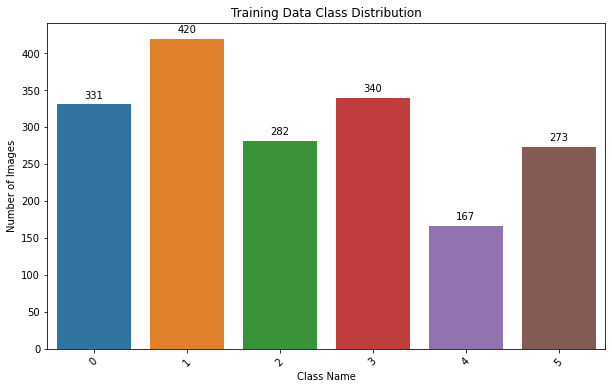

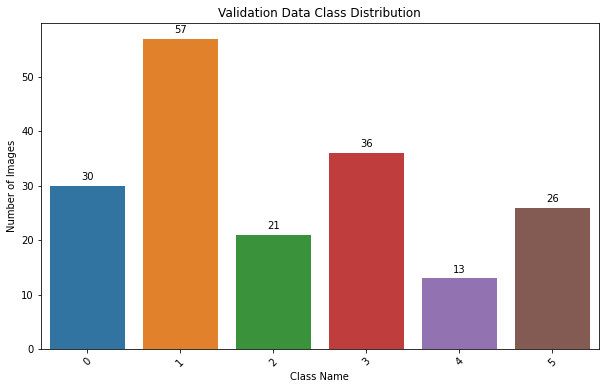

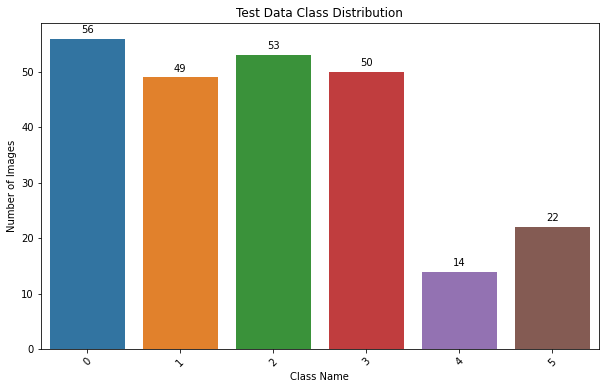

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스별 이미지 개수 계산 함수
def plot_class_distribution(images, labels, title):
    class_counts = pd.Series(labels).value_counts().sort_index()
    
    # 막대 그래프 그리기
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x=class_counts.index, y=class_counts.values)
    
    # 각 막대에 숫자 표시
    for p in barplot.patches:
        barplot.annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')
    
    # 그래프 제목 및 레이블 설정
    plt.title(title)
    plt.xlabel('Class Name')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.show()

# 학습 데이터셋 시각화
plot_class_distribution(train_images, train_labels, 'Training Data Class Distribution')

# 검증 데이터셋 시각화
plot_class_distribution(valid_images, valid_labels, 'Validation Data Class Distribution')

# 테스트 데이터셋 시각화
plot_class_distribution(test_images, test_labels, 'Test Data Class Distribution')

In [5]:
# 훈련 데이터셋 이미지 shape 확인
print("훈련 데이터셋(train_images) 이미지의 shape:", train_images.shape)

# 테스트 데이터셋 이미지 shape 확인
print("테스트 데이터셋(test_images) 이미지의 shape:", test_images.shape)

# 검증 데이터셋 이미지 shape 확인
print("검증 데이터셋(valid_images) 이미지의 shape:", valid_images.shape)

훈련 데이터셋(train_images) 이미지의 shape: (1813, 224, 224, 3)
테스트 데이터셋(test_images) 이미지의 shape: (244, 224, 224, 3)
검증 데이터셋(valid_images) 이미지의 shape: (183, 224, 224, 3)


- 추가 데이터확보과정에서 균일한 데이터 확보에는 실패했지만, 기존의 데이터보다 더 확연히 늘어난 볼륨을 확인할 수 있습니다
    - 기존 검증데이터 6개 클래스 총합 39개이미지, 테스트 데이터 6개 클래스 총합 40개 이미지
- 학습 데이터는 imbalance를 해결하기 위해 데이터 크기에 가중치를 부여해 학습시 치중되는 현상을 제어할 예정입니다.
- 검증데이터와 테스트 데이터의 경우 불균형한 데이터를 그대로 사용하여 모델의 성능을 평가합니다.

### 이미지 시각화

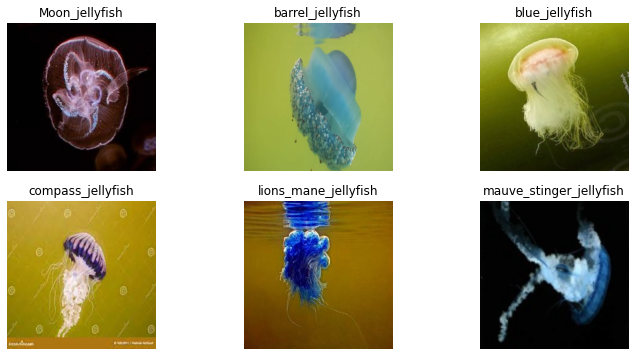

In [6]:
import random

# 클래스의 이름과 수를 파악합니다.
class_names = train_classes  # train_images에서 train_classes로 변경
num_classes = len(class_names)

# 1행: 클래스 별로 랜덤한 이미지 선택하여 출력
plt.figure(figsize=(12, 6))
for i in range(num_classes):
    class_images = train_images[train_labels == i]  # 해당 클래스의 이미지 가져오기
    if len(class_images) > 0:  # 해당 클래스에 이미지가 있는지 확인
        random_index = random.randint(0, len(class_images) - 1)  # 랜덤한 이미지 인덱스 선택
        selected_image = class_images[random_index]

        # 이미지를 정규화 해제하여 BGR 색상으로 변환
        restored_image = selected_image * 255.0  # 정규화를 해제하기 위해 255를 곱합니다.
        restored_image = restored_image.astype("uint8")  # 정수형 데이터로 변환합니다.
        restored_image = cv2.cvtColor(restored_image, cv2.COLOR_RGB2BGR)  # RGB에서 BGR로 변환합니다.

        plt.subplot(2, 3, i + 1)
        plt.imshow(restored_image)
        plt.title(class_names[i])  # 클래스 이름을 제목으로 표시
        plt.axis("off")

plt.show()

## 모델링

- 추가데이터를 확보했다고는 하지만 여전히 기본적으로 학습할 데이터셋의 규모가 매우 작은 편입니다.
- 데이터 증강을 통해 데이터의 규모를 일부 증가시켜 최대한 데이터의 볼륨을 증가시키고자 하였습니다.
- CNN_V1은 가장 기본적인 CNN모델 구조를 사용해서 baseline model로 설정하고자 하였습니다.
    - Conv2D 레이어를 통해 이미지의 지역적 특성을 추출하고, MaxPooling2D 레이어로 feature map의 크기를 줄여 정보를 보존하는 구조입니다.
    - 이후 Flatten 레이어에 데이터를 전달해 1차원으로 변환하여 Dense 레이어에서 분류를 수행합니다.
    - 데이터의 수가 워낙 적기 때문에 과적합 방지를 위해 dropout을 적용했습니다.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator


def CNN_V1():
    model = Sequential()

    # 첫 번째 convolution 레이어와 활성화 함수 추가
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)))
    model.add(Activation('relu'))

    # 두 번째 convolution 레이어와 활성화 함수 추가
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # max pooling 레이어와 드롭아웃 레이어 추가
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 세 번째 합성곱 레이어와 활성화 함수 추가
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # 두 번째 맥스 풀링 레이어와 드롭아웃 레이어 추가
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # flatten 레이어 추가
    model.add(Flatten())

    # 첫 번째 밀집 레이어와 활성화 함수 추가
    model.add(Dense(128))
    model.add(Activation('relu'))

    # 두 번째 dense 레이어와 활성화 함수 추가
    model.add(Dense(32))
    model.add(Activation('relu'))

    # 출력 레이어 추가
    model.add(Dense(6, activation='softmax'))

    return model

# 모델 선언
CNN_V1_model = CNN_V1()

# 모델 요약
CNN_V1_model.summary()

# 모델 컴파일
CNN_V1_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 이미지 데이터 증강을 위한 데이터 제너레이터 생성
datagen = ImageDataGenerator(
    rotation_range=30,         # 이미지를 랜덤하게 30도 회전
    width_shift_range=0.1,     # 가로로 10%까지 랜덤하게 이동
    height_shift_range=0.1,    # 세로로 10%까지 랜덤하게 이동
    shear_range=0.1,           # 레이어를 변형
    zoom_range=0.3,            # 30% 범위로 확대 또는 축소
    horizontal_flip=True,      # 가로로 뒤집기
    vertical_flip=True,        # 세로로 뒤집기
)

datagen1 = ImageDataGenerator()

# 데이터 증강을 위한 데이터 제너레이터 생성
train_datagen = datagen.flow(train_images, train_labels, batch_size=20)
val_datagen = datagen1.flow(valid_images, valid_labels, batch_size=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      1

### 클래스 Imbalance 해결 위한 가중치 계산

In [8]:
# 클래스별 데이터 개수를 계산
class_counts = pd.Series(train_labels).value_counts()

total_samples = len(train_datagen)
class_weights = {cls: total_samples / (num_samples * len(class_counts)) for cls, num_samples in class_counts.items()}

#print("클래스 가중치:", class_weights)

## 모델 학습

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 콜백 정의
model_checkpoint_callback = ModelCheckpoint(filepath='CNN_V1.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = CNN_V1_model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[model_checkpoint_callback], class_weight=class_weights)

Epoch 1/150
91/91 [==============================] - 22s 187ms/step - loss: 0.0975 - accuracy: 0.2830 - val_loss: 1.5428 - val_accuracy: 0.3716
Epoch 2/150
91/91 [==============================] - 18s 192ms/step - loss: 0.0735 - accuracy: 0.4071 - val_loss: 1.4258 - val_accuracy: 0.4590
Epoch 3/150
91/91 [==============================] - 17s 191ms/step - loss: 0.0678 - accuracy: 0.4567 - val_loss: 1.3745 - val_accuracy: 0.4645
Epoch 4/150
91/91 [==============================] - 18s 192ms/step - loss: 0.0638 - accuracy: 0.4732 - val_loss: 1.3226 - val_accuracy: 0.5137
Epoch 5/150
91/91 [==============================] - 18s 192ms/step - loss: 0.0623 - accuracy: 0.4942 - val_loss: 1.1586 - val_accuracy: 0.5902
Epoch 6/150
91/91 [==============================] - 17s 191ms/step - loss: 0.0615 - accuracy: 0.5052 - val_loss: 1.2663 - val_accuracy: 0.4973
Epoch 7/150
91/91 [==============================] - 18s 193ms/step - loss: 0.0590 - accuracy: 0.5273 - val_loss: 1.2241 - val_accuracy:

### 학습 결과 시각화

In [10]:
import seaborn as sns

def plot_accuracy_and_loss(history):
    # seaborn 스타일 설정
    sns.set(style="whitegrid")

    # Train 및 Val Accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Train 및 Val Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # 에포크 범위
    epochs_range = range(len(acc))

    # 그래프 크기 설정
    plt.figure(figsize=(12, 6))

    # Accuracy 그래프
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Train Accuracy', color='blue')
    sns.lineplot(x=epochs_range, y=val_acc, label='Val Accuracy', color='red')
    plt.title('Train & Val Accuracy')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Train Loss', color='blue')
    sns.lineplot(x=epochs_range, y=val_loss, label='Val Loss', color='red')
    plt.title('Train & Validation Loss')
    plt.legend()

    plt.show()

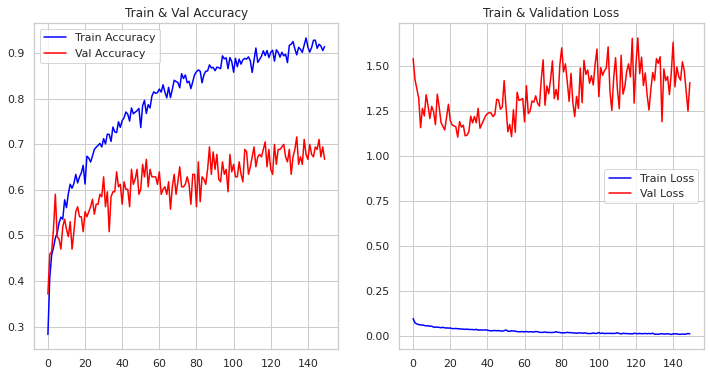

In [13]:
# 학습 결과를 시각화
plot_accuracy_and_loss(history)

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 가장 높은 정확도를 가진 epoch를 찾습니다.
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Epoch가 1부터 시작하기때문에 +1을 합니다.

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

CNN_V1_model.save(f"CNN_V1_adddata_best_model_epoch_{best_epoch}.h5")

Best Accuracy: 0.8958 at Epoch 135
Best Validation Accuracy: 0.7158 at Epoch 135


### 모델 성능 테스트

In [15]:
from tensorflow.keras.models import load_model

# 가장 최적의 모델 불러오기
best_model = load_model(f"CNN_V1_adddata_best_model_epoch_{best_epoch}.h5")

# 테스트 데이터셋 평가
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

8/8 - 1s - loss: 1.1171 - accuracy: 0.7336
Test Accuracy: 73.36%


### 모델 성능 평가 및 개선방안 수립

- V1 모델의 성능이 나쁜것은 아니지만, 학습과 검증 데이터간의 loss나 acc의 차이나 추이를 볼때 과적합이 의심됩니다.
- 따라서 모델의 일반화 성능 향상을 위해 Conv2D 레이어 뒤에 Layer Normalization을 추가했습니다.
    - 이를 통해 레이어의 출력을 정규화해 학습을 안정화하여 과적합을 억제하고 모델 성능 향상을 기대할 수 있습니다.
- 추가로 MaxPooling의 크기를 변경해 4 x 4로 증가를 시도합니다.
    - 풀링 레이어의 크기를 키움으로 인해 이미지의 지역정 정보를 더 집약적으로 변경하고자 했습니다.
- Conv2D 레이어의 필터수를 변경했습니다.
    - V1에서는 1~3번째 Conv2D 레이어에는 각각 16, 32, 64개의 필터를 사용했었습니다.
    - 이번에는 모든 레이어에 32개의 필터를 사용합니다.
    - 모델이 과적합되는 것을 방지하기 위한 시도입니다.

## CNN_V2

In [16]:
def CNN_V2():
    # Sequential 모델 정의
    model = tf.keras.models.Sequential([
        # 첫 번째 합성곱 레이어: 32개의 필터, 3x3 크기의 커널, 활성화 함수 ReLU
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),

        # 레이어 정규화 추가
        tf.keras.layers.LayerNormalization(),

        # 맥스 풀링 레이어: 4x4 크기의 풀링
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 두 번째 합성곱 레이어: 32개의 필터, 3x3 크기의 커널, 활성화 함수 ReLU
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),

        # 레이어 정규화 추가
        tf.keras.layers.LayerNormalization(),

        # 두 번째 맥스 풀링 레이어: 4x4 크기의 풀링
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 세 번째 합성곱 레이어: 32개의 필터, 3x3 크기의 커널, 활성화 함수 ReLU
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),

        # 레이어 정규화 추가
        tf.keras.layers.LayerNormalization(),

        # 세 번째 맥스 풀링 레이어: 4x4 크기의 풀링
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 데이터를 1차원으로 펼치는 레이어
        tf.keras.layers.Flatten(),

        # 첫 번째 밀집 레이어: 128개의 뉴런, 활성화 함수 ReLU
        tf.keras.layers.Dense(128, activation='relu'),

        # 출력 레이어: 클래스 수에 맞춰 6개의 뉴런, 활성화 함수 Softmax
        tf.keras.layers.Dense(6, activation='softmax')  
        ])
    
    return model

# 모델 선언
CNN_V2_model = CNN_V2()
    
# 모델 요약
CNN_V2_model.summary()


# 모델 컴파일
CNN_V2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
layer_normalization (LayerNo (None, 224, 224, 32)      64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
layer_normalization_1 (Layer (None, 56, 56, 32)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)       

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 콜백 정의
model_checkpoint_callback = ModelCheckpoint(filepath='CNN_V2_added_data.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = CNN_V2_model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[model_checkpoint_callback], class_weight=class_weights)

Epoch 1/150
91/91 [==============================] - 20s 198ms/step - loss: 0.0913 - accuracy: 0.2344 - val_loss: 1.6151 - val_accuracy: 0.3716
Epoch 2/150
91/91 [==============================] - 18s 201ms/step - loss: 0.0807 - accuracy: 0.3320 - val_loss: 1.6070 - val_accuracy: 0.2732
Epoch 3/150
91/91 [==============================] - 18s 201ms/step - loss: 0.0703 - accuracy: 0.4291 - val_loss: 1.2762 - val_accuracy: 0.5027
Epoch 4/150
91/91 [==============================] - 18s 202ms/step - loss: 0.0668 - accuracy: 0.4523 - val_loss: 1.2617 - val_accuracy: 0.4918
Epoch 5/150
91/91 [==============================] - 18s 199ms/step - loss: 0.0616 - accuracy: 0.5168 - val_loss: 1.1639 - val_accuracy: 0.5464
Epoch 6/150
91/91 [==============================] - 18s 200ms/step - loss: 0.0582 - accuracy: 0.5394 - val_loss: 1.1835 - val_accuracy: 0.5137
Epoch 7/150
91/91 [==============================] - 18s 202ms/step - loss: 0.0558 - accuracy: 0.5720 - val_loss: 1.0862 - val_accuracy:

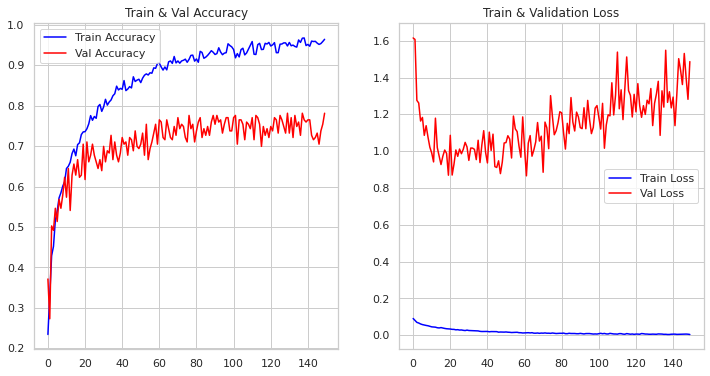

In [18]:
# 학습 결과를 시각화
plot_accuracy_and_loss(history)

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 가장 높은 정확도를 가진 epoch를 찾습니다.
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Epoch가 1부터 시작하기때문에 +1을 합니다.

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

CNN_V2_model.save(f"CNN_V2_adddata_best_model_epoch_{best_epoch}.h5")

Best Accuracy: 0.9476 at Epoch 130
Best Validation Accuracy: 0.7814 at Epoch 130


### 모델성능 테스트

In [20]:
from tensorflow.keras.models import load_model

# 가장 최적의 모델 불러오기
best_model = load_model(f"CNN_V2_adddata_best_model_epoch_{best_epoch}.h5")

# 테스트 데이터셋 평가
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

8/8 - 1s - loss: 1.1684 - accuracy: 0.7582
Test Accuracy: 75.82%


### 모델 성능 평가 및 개선방안 수립

- V1에 비해서 모델성능이 소폭 향상되었습니다.
- 다만 학습 곡선을 보면 학습 데이터에 대해서는 모델의 성능이 좋아지고 있는데 반해, 검증 데이터의 경우 특정 epoch이후 정확도도 일정 수준에 수렴하고, loss는 오히려 증가하는 추세를 보여주어 과적합이 관찰됩니다.
- 따라서 모델의 과적합을 개선하기 위해 두가지 조치를 취해 V3모델을 구성해보겠습니다.

---

- Dropout 추가
    - 가장 보편적인 방법으로 드롭아웃 레이어를 추가하였습니다.
- GAP 사용
    - V2에서는 Dense 레이어에서 예측을 하기에 앞서 Flatten 레이어에서 고차원 특성을 평탄화 합니다.
    - 이과정은 모델 파라미터수를 급증시켜 과적합유발의 원인이 되기도 합니다.
    - 이를 Global Average Pooloing으로 변경해서 전체적인 정보를 보존하면서 파라미터수를 감소시켜 과적합을 줄이고, 모델이 중요한 특성을 더 잘학습할 수 있도록 유도합니다.

## CNN_V3

In [21]:
def CNN_V3():
    # Sequential 모델 정의
    model = tf.keras.models.Sequential([
        # 첫 번째 합성곱 레이어 (올바른 이름인 Conv2D로 수정)
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 드롭아웃 추가 (예를 들어, 드롭아웃 비율을 0.2로 설정)
        tf.keras.layers.Dropout(0.2),

        # 두 번째 합성곱 레이어
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 드롭아웃 추가
        tf.keras.layers.Dropout(0.2),

        # 세 번째 합성곱 레이어
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # Global Average Pooling 사용
        tf.keras.layers.GlobalAveragePooling2D(),

        # 첫 번째 밀집 레이어
        tf.keras.layers.Dense(128, activation='relu'),

        # 드롭아웃 추가
        tf.keras.layers.Dropout(0.2),

        # 출력 레이어
        tf.keras.layers.Dense(6, activation='softmax')  
        ])
    return model

# 모델 선언
CNN_V3_model = CNN_V3()
    
# 모델 요약
CNN_V3_model.summary()

# 모델 컴파일
CNN_V3_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
layer_normalization_3 (Layer (None, 224, 224, 32)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
layer_normalization_4 (Layer (None, 56, 56, 32)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)       

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 콜백 정의
model_checkpoint_callback = ModelCheckpoint(filepath='CNN_V3_added_data.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = CNN_V3_model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[model_checkpoint_callback], class_weight=class_weights)

Epoch 1/150
91/91 [==============================] - 20s 203ms/step - loss: 0.0905 - accuracy: 0.2344 - val_loss: 1.6079 - val_accuracy: 0.3388
Epoch 2/150
91/91 [==============================] - 18s 201ms/step - loss: 0.0815 - accuracy: 0.3089 - val_loss: 1.5155 - val_accuracy: 0.3443
Epoch 3/150
91/91 [==============================] - 18s 202ms/step - loss: 0.0759 - accuracy: 0.3767 - val_loss: 1.3768 - val_accuracy: 0.4426
Epoch 4/150
91/91 [==============================] - 18s 201ms/step - loss: 0.0703 - accuracy: 0.4391 - val_loss: 1.3577 - val_accuracy: 0.4536
Epoch 5/150
91/91 [==============================] - 18s 201ms/step - loss: 0.0699 - accuracy: 0.4335 - val_loss: 1.2841 - val_accuracy: 0.4973
Epoch 6/150
91/91 [==============================] - 18s 202ms/step - loss: 0.0665 - accuracy: 0.4716 - val_loss: 1.2743 - val_accuracy: 0.4754
Epoch 7/150
91/91 [==============================] - 18s 202ms/step - loss: 0.0651 - accuracy: 0.4815 - val_loss: 1.2741 - val_accuracy:

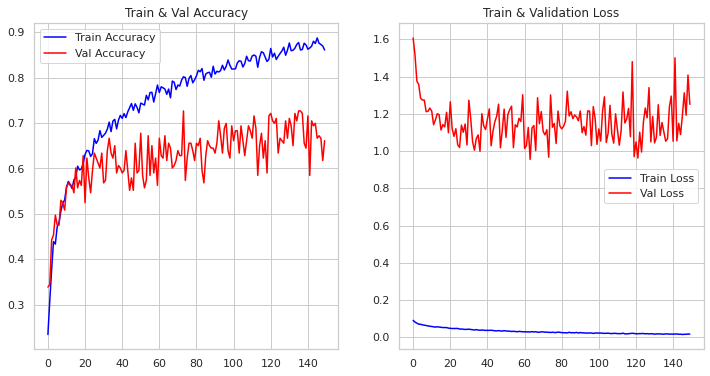

In [23]:
# 학습 결과를 시각화
plot_accuracy_and_loss(history)

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 가장 높은 정확도를 가진 epoch를 찾습니다.
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Epoch가 1부터 시작하기때문에 +1을 합니다.

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

CNN_V3_model.save(f"CNN_V3_adddata_best_model_epoch_{best_epoch}.h5")

Best Accuracy: 0.8020 at Epoch 74
Best Validation Accuracy: 0.7268 at Epoch 74


In [25]:
from tensorflow.keras.models import load_model

# 가장 최적의 모델 불러오기
best_model = load_model(f"CNN_V3_adddata_best_model_epoch_{best_epoch}.h5")

# 테스트 데이터셋 평가
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

8/8 - 1s - loss: 0.9930 - accuracy: 0.7295
Test Accuracy: 72.95%


### 모델 성능 평가 및 개선방안 수립

- V2에서 모델개선을 시도한 V3에서는 외려 모델의 성능이 하락하고 이전 보다 더 심한 과적합 현상을 보여주고 있습니다.
- 필터 수 감소
    - 데이터의 수는 적은데 반해 V3 모델에서 너무 많은 필터를 사용해서 모델의 복잡도가 높아진 것이 과적합의 주된 원인일 수 있습니다.
    - 따라서 모델 파라미터 수를 줄이기 위해 필터를 줄여보도록 하겠습니다.
- MaxPooling 크기 조정
    - V3에서는 4 x 4 맥스 풀링을 사용했지만 V4에는 이를 줄여 feature map이 중요한 공간정보의 특성을 유지하도록 하기 위한 시도 입니다.
- 추가적 Dense layer 적용
    - Dense 레이어를 추가하여 모델이 더 복합한 연산도 수행할 수 있도록 수정했습니다.
    - 이를 통해 모델이 다소 추상적인 데이터들의 특성도 파악할 수 있을 것이라 기대합니다.

## CNN_V4

In [26]:
# 모델을 생성하는 함수 CNN_V4를 정의합니다.
def CNN_V4():
    # Sequential 모델을 생성합니다.
    model = Sequential([
        # 16개의 필터를 가지고 3x3 크기의 컨볼루션 레이어를 생성하며, 입력 이미지의 크기는 (224, 224, 3)입니다.
        Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)),
        Activation('relu'),
        
        # 32개의 필터를 가지고 3x3 크기의 컨볼루션 레이어를 생성합니다.
        Conv2D(32, (3, 3), padding='same'),
        Activation('relu'),
        
        # 2x2 크기의 맥스 풀링 레이어를 추가합니다.
        MaxPooling2D(pool_size=(2, 2)),
        
        # 드롭아웃 레이어를 추가합니다.
        Dropout(0.25),

        # 64개의 필터를 가지고 3x3 크기의 컨볼루션 레이어를 생성합니다.
        Conv2D(64, (3, 3), padding='same'),
        Activation('relu'),
        
        # 다시 2x2 크기의 맥스 풀링 레이어를 추가합니다.
        MaxPooling2D(pool_size=(2, 2)),
        
        # 드롭아웃 레이어를 추가합니다.
        Dropout(0.25),

        # 모든 뉴런을 연결하는 플래튼 레이어를 추가합니다.
        Flatten(),
        
        # 128개의 뉴런을 가지고 활성화 함수로 ReLU를 사용하는 밀집 레이어를 추가합니다.
        Dense(128),
        Activation('relu'),
        
        # 32개의 뉴런을 가지고 활성화 함수로 ReLU를 사용하는 밀집 레이어를 추가합니다.
        Dense(32),
        Activation('relu'),
        
        # 출력 레이어로 6개의 클래스를 분류하는 소프트맥스 활성화 함수를 사용합니다.
        Dense(6, activation='softmax')
    ])
    
    # 모델을 반환합니다.
    return model

# 모델 선언
CNN_V4_model = CNN_V4()
    
# 모델 요약
CNN_V4_model.summary()

# 모델 컴파일
CNN_V4_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
activation_6 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 64)     

In [27]:
# 모델 저장 콜백 정의
model_checkpoint_callback = ModelCheckpoint(filepath='CNN_V4_added_data.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = CNN_V4_model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[model_checkpoint_callback], class_weight=class_weights)

Epoch 1/150
91/91 [==============================] - 18s 191ms/step - loss: 0.0994 - accuracy: 0.2449 - val_loss: 1.6689 - val_accuracy: 0.2568
Epoch 2/150
91/91 [==============================] - 18s 192ms/step - loss: 0.0777 - accuracy: 0.3502 - val_loss: 1.5021 - val_accuracy: 0.4098
Epoch 3/150
91/91 [==============================] - 17s 191ms/step - loss: 0.0710 - accuracy: 0.4159 - val_loss: 1.4040 - val_accuracy: 0.4645
Epoch 4/150
91/91 [==============================] - 17s 189ms/step - loss: 0.0689 - accuracy: 0.4506 - val_loss: 1.3298 - val_accuracy: 0.4809
Epoch 5/150
91/91 [==============================] - 17s 190ms/step - loss: 0.0655 - accuracy: 0.4810 - val_loss: 1.2903 - val_accuracy: 0.4863
Epoch 6/150
91/91 [==============================] - 17s 190ms/step - loss: 0.0659 - accuracy: 0.4710 - val_loss: 1.3437 - val_accuracy: 0.5191
Epoch 7/150
91/91 [==============================] - 17s 189ms/step - loss: 0.0650 - accuracy: 0.4843 - val_loss: 1.3253 - val_accuracy:

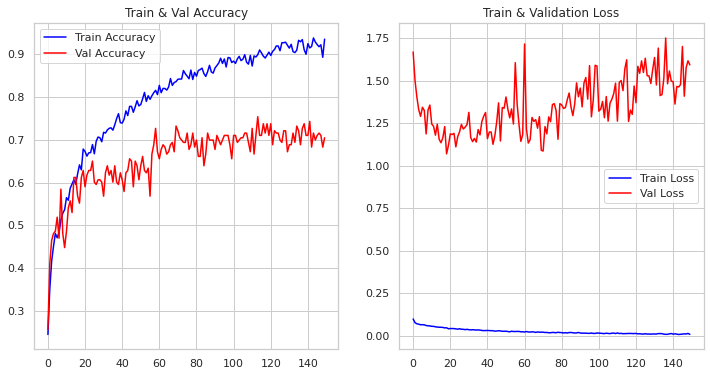

In [28]:
# 학습 결과를 시각화
plot_accuracy_and_loss(history)

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 가장 높은 정확도를 가진 epoch를 찾습니다.
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Epoch가 1부터 시작하기때문에 +1을 합니다.

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

CNN_V4_model.save(f"CNN_V4_adddata_best_model_epoch_{best_epoch}.h5")

Best Accuracy: 0.8991 at Epoch 114
Best Validation Accuracy: 0.7541 at Epoch 114


In [32]:
from tensorflow.keras.models import load_model

# 가장 최적의 모델 불러오기
best_model = load_model(f"CNN_V4_adddata_best_model_epoch_{best_epoch}.h5")

# 테스트 데이터셋 평가
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels, verbose=2)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

8/8 - 0s - loss: 1.2085 - accuracy: 0.7213
Test Accuracy: 72.13%


### 모델 성능 평가 및 개선방안 수립

- 기대했던것에 반해 드라마틱한 모델의 성능 향상은 없었고 외려 성능이 소폭 하락했습니다.
- 과적합에 대한 억제는 제대로 수행되지 못했습니다.
- 여러 이유가 있겠으나 가장 주된 원인은 데이터의 볼륨이 적고 학습데이터에 대해 모델이 과적합되는 것입니다.
- 이는 학습데이터에 비해 검증데이터의 다양성도 볼륨도 적은 것이 가장 큰 원인이라 생각됩니다.
- 데이터의 추가 수집에는 한계가 있고, 데이터 증강도 이미 원본 데이터부터 여러번 적용했던 사항이라 누적된 증강이 모델 성능 향상에 큰 효과를 내리라 기대하기는 어렵습니다.